Import Dependencies
-

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

import time
import sys

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

Define Structure of Feature Space as a Graph
-

In [4]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

Calculate Feature-Interaction Cluster
-

            query_node2 [0 0] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0. 0.]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-55.63144191  40.31786889] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.16429958  0.1140423 ]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-111.26288382   80.63573777] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.32859917  0.2280846 ]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-166.89432573  120.95360666] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.49289875  0.3421269 ]
              fmax 0
              cluster [-1.  1.]
1            query_node2 [-67.0417826    9.97837588] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
      

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.1559596  -0.05410455]
              fmax 0
              cluster [1. 0.]
            query_node2 [ 52.80754377 -19.12781446] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.1559596  -0.05410455]
              fmax 0
              cluster [1. 0.]
            query_node2 [ 52.15559879 -19.12781446] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.15403417 -0.05410455]
              fmax 0
              cluster [1. 0.]
            query_node2 [ 52.15559879 -19.12781446] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.15403417 -0.05410455]
              fmax 0
              cluster [1. 0.]
            query_node2 [ 51.5036538  -19.12781446] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.

            query_node2 [50.27657794 48.15240315] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.14848475 0.13620291]
              fmax 0
              cluster [1. 1.]
            query_node2 [49.70525319 47.60521675] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.14679743 0.13465515]
              fmax 0
              cluster [1. 1.]
            query_node2 [49.70525319 47.60521675] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.14679743 0.13465515]
              fmax 0
              cluster [1. 1.]
            query_node2 [49.13392844 47.05803035] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.1451101  0.13310738]
              fmax 0
              cluster [1. 1.]
            query_node2 [49.13392844 47.05803035] source_node2 [0 0]
              feat_scaler [0.00295336 0.0028285

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.0134635 ]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    4.75981028] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.0134635 ]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    4.69955951] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.01329308]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    4.69955951] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.01329308]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    4.63930875] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.399

            query_node2 [-135.31604725    1.74727213] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.0049423 ]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    1.74727213] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.0049423 ]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    1.68702136] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.00477187]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    1.68702136] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.39963678  0.00477187]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-135.31604725    1.6267706 ] source_node2 [0 0]
           

            query_node2 [-18.41065897 209.13531929] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.05437327  0.5915559 ]
              fmax 1
              cluster [0. 1.]
            query_node2 [-18.41065897 207.02284132] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.05437327  0.58558059]
              fmax 1
              cluster [0. 1.]
            query_node2 [-18.41065897 207.02284132] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.05437327  0.58558059]
              fmax 1
              cluster [0. 1.]
            query_node2 [-18.41065897 204.91036335] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.05437327  0.57960527]
              fmax 1
              cluster [0. 1.]
            query_node2 [-18.41065897 204.91036335] source_node2 [0 0]
              feat_scaler [0.

              fmax 0
              cluster [-1.  1.]
            query_node2 [-227.94901776  157.18911834] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.44462193]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-227.94901776  155.00593614] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.43844663]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-227.94901776  155.00593614] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.43844663]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-227.94901776  152.82275395] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.43227132]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-227.9

            query_node2 [-227.94901776   67.67864818] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.19143444]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-227.94901776   67.67864818] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.19143444]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-227.94901776   65.49546598] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.18525914]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-227.94901776   65.49546598] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.18525914]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-227.94901776   63.31228378] source_node2 [0 0]
           

            query_node2 [-227.94901776    2.1831822 ] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.0061753 ]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-227.94901776    2.1831822 ] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.0061753 ]
              fmax 0
              cluster [-1.  0.]
5 min_node <__main__.Node object at 0x7fc9140bc890>
            query_node2 [-227.94901776    2.1831822 ] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67321514  0.0061753 ]
              fmax 0
              cluster [-1.  0.]


 Adjs
Query: [-227.94901776    2.1831822 ]
[0. 0.]
[-230.22850793  220.50140212]
[-230.22850793 -220.50140212]

            query_node2 [0. 0.] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0. 0.]
           

              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.679

              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
          

              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.67994729 -0.62370577]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-230.22850793 -220.50140212

              fmax 1
              cluster [ 1. -1.]
            query_node2 [  96.22855703 -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.28419741 -0.5252633 ]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [  95.24663298 -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.28129744 -0.5252633 ]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [  95.24663298 -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.28129744 -0.5252633 ]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [  94.26470893 -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.27839747 -0.5252633 ]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [  94.2

              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.22619794 -0.5252633 ]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  76.590076   -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.22619794 -0.5252633 ]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  75.60815195 -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.22329797 -0.5252633 ]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  75.60815195 -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.22329797 -0.5252633 ]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  74.6262279  -185.69860859] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.220

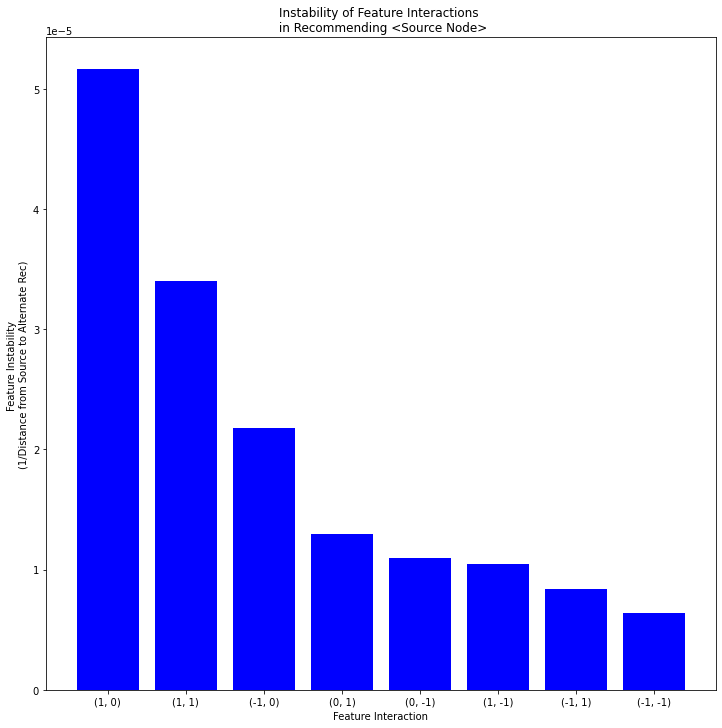

In [620]:
# Puts solution node into a n-way feature interaction cluster, and tell which cluster
def cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler):
    
    #print("query_node1",query_node.position, "source_node1",source_node.position)
    soln_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
                
    if tuple(soln_cluster) not in solution_clusters:
        solution_clusters[tuple(soln_cluster)] = []

    solution_clusters[tuple(soln_cluster)].append(query_node.position)
    
    return solution_clusters #returns full cluster list


def calc_feat_cluster(source_node, query_node, feat_scaler):
    
    print("            query_node2",query_node.position, "source_node2",source_node.position)
    print("              feat_scaler",feat_scaler)
    relative_node_pos = (query_node.position - source_node.position) #Projects pos of query relative to source
    scaled_feats = (relative_node_pos * feat_scaler) #[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    soln_cluster = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    print("              scaled_feats",scaled_feats)
    print("              fmax",f_max)
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                soln_cluster[f_i] = 1
            else:
                soln_cluster[f_i] = -1
    
    if scaled_feats[f_max] > 0:
        soln_cluster[f_max] = 1
    else:
        soln_cluster[f_max] = -1
        
    print("              cluster",soln_cluster)
        
    return soln_cluster.astype(int)
    

source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
feat_scaler = 1/np.asarray(feat_ranges)
solution_clusters = {}
query_node = Node(np.asarray([100,100]), None)
query_node.distance = get_distance(source_node, query_node, feat_scaler)

np.random.seed(seed=12)

prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=5, k=20)
solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, k=1000)

sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
display_instability(sorted_clusters)

0.0029533583682467214

Define Synthetic Model
-
Given d-dimensional feature space, the synthetic_model() mathemtatically defines a ground truth decision boundary, such that all points within the bounds of a solution cluster are all a distance r from the source node position

In [296]:
#Define feature importance to be represented in synthetic model

source_node = Node(np.asarray([0,0]), 0) #Want to explain this value
query_node = Node(np.asarray([11,5]), 0)

#Define scaling for features in synthetic "training data"
feat_ranges = np.zeros(len(source_node.position)) + 200 #Assume all features have range 1000
feat_scaler = 1/np.asarray(feat_ranges)
    

#Want GD-FETS to recreate these stability values thorugh local search
ground_truth_importance = {}
ground_truth_importance[(1,0)] = 30
ground_truth_importance[(1,1)] = 60
ground_truth_importance[(-1,0)] = 120
ground_truth_importance[(0,0)] = 200 #default for every other feature interaction

In [407]:
#Non-linear example of synethetic model
def query_synth_model(ground_truth_importance, source_node, query_node):
    
    #Determine cluster of query_node
    cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    relative_position = query_node.position - source_node.position
    
    # create n feature hyper-arc specific to cluster
    distance = 0
    for term in relative_position:
        distance += abs(term) ** 2
    distance = distance ** 0.5
        
    if tuple(cluster) in ground_truth_importance.keys():
        decision_threshold = ground_truth_importance[tuple(cluster)]
    else:
        default_index = tuple(np.zeros(len(relative_position)))
        decision_threshold = ground_truth_importance[default_index]
        
    if distance < decision_threshold:
        return 0
    else:
        return 1

2


Generate Training Data
-

(1000, 2)

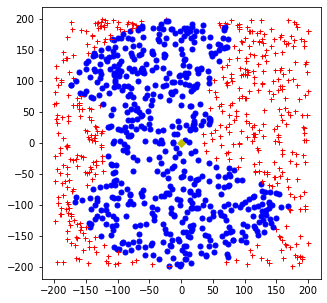

In [38]:
#Create "training data" to use for calculating feat_ranges to infer search step sizes
fig, ax = plt.subplots(figsize = (5, 5))
#plt.ylim(-2,2)
#plt.xlim(-2,2)

feat_range = feat_ranges[0]
nfeats = len(source_node.position)
dense_features = np.arange(nfeats)
data = []
labels = []
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-1*feat_range, high=feat_range, size=(nfeats,))
    query_node = Node(point, None)
    rec = query_synth_model(ground_truth_importance, source_node, query_node)
    data.append(point)
    labels.append(rec)
    
    if rec == 0:
        plt.plot(point[0],point[1],'bo',markersize=5)
    else:
        plt.plot(point[0],point[1],'r+',markersize=5)

plt.plot(source_node.position[0],source_node.position[1],'yD',markersize=5)
data = pd.DataFrame(data)
data.shape

Determine Scaling Range for Distance
-

In [39]:
def get_num_range(data, dense_features):
    #Returns (range) of values for each I1-I13 integer features
    num_data_distrib = []
    for feat in dense_features:
        feature = data[feat]
        #num_data_distrib.append([feature.min(), feature.max(), np.std(feature), feature.mean()])
        #num_data_distrib.append([feature.min(), feature.max(), feature.max() - feature.min()])
        #num_data_distrib.append([feature.max() - feature.min()])
        num_data_distrib.append(3 * np.std(feature)) #Range contains 99.7% of samples in training data
    
    return np.asarray(num_data_distrib)
    
feat_ranges = get_num_range(data, dense_features)
print(feat_ranges.shape)
feat_ranges

(2,)


array([338.59758123, 353.53433206])

Generate Uniform Distribution of Unit Vectors in d-dimensional space
-

In [40]:
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        v_hat = v / np.linalg.norm(v)
        vectors.append(v_hat)
    return vectors

Find k-way Feature-Interaction Solutions Surrounding Source Node
-

In [70]:
def generate_precursor_solutions(source_node, feat_ranges, k=20, nsteps=6, plot_search=False):
    
    step_sizes = (feat_ranges/nsteps) #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.arange(step_sizes[feat],feat_ranges[feat],step_sizes[feat]))
    feat_steps = np.asarray(feat_steps)
    
    source_rec = query_synth_model(ground_truth_importance, source_node, source_node)
    
    if plot_search:
        plt.plot(source_node.position[0],source_node.position[1],'r+')

    discovered = []

    while len(discovered) < k:
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        for step in range(nsteps-1):
            scaled_vector_position = np.asarray(unit_vector * feat_steps.T[step] + source_node.position)
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_synth_model(ground_truth_importance, source_node, scaled_vector)
            
            if plot_search:
                if query_rec == source_rec:
                    color = 'bo'
                else:
                    color = 'y^'
                plt.plot(scaled_vector.position[0],scaled_vector.position[1],color)
            
            if source_rec != query_rec:
                # distance heuristic
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                print(len(discovered),end='')
                break

    return discovered #prelim_discovered

source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
feat_ranges = get_num_range(data, dense_features)
feat_scaler = 1/np.asarray(feat_ranges)
query_node = Node(np.asarray([5,5]), None)
solution_clusters = {}

prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, k=20)

1234567891011121314151617181920

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Calculate Distance from Source to Query Node
-

In [73]:
def get_distance(source_node, query_node, feat_scaler, distance='Manhattan'):
    #returns distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = (dif / feat_scaler)
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)

----

Display Shortest Clusters Found During Outside-In Search
-

In [44]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    
    sorted_clusters = np.asarray(sorted_clusters)
    ind = sorted_clusters.argsort(axis=0)
    sorted_clusters[:,0] = sorted_clusters[:,0][ind[:,0]]
    sorted_clusters[:,1] = sorted_clusters[:,1][ind[:,0]]
    
    return sorted_clusters

In [45]:
def display_instability(sorted_clusters):
    x = [str(feat_interaction[1]) for feat_interaction in sorted_clusters]
    energy = [1/feat_interaction[0] for feat_interaction in sorted_clusters]
    variance = [0 for _ in x]

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, energy, color='blue', yerr=variance)
    plt.xlabel("Feature Interaction")
    plt.ylabel("Feature Instability \n(1/Distance from Source to Alternate Rec)")
    plt.title("Instability of Feature Interactions \n in Recommending <Source Node>")

    plt.xticks(x_pos, x)

    font = {'weight' : 'bold',
            'size'   : 12}

    #matplotlib.rc('font', **font)

    #plt.rcParams["figure.figsize"] = (5,5)
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.show()

A* Cluster Search
-

In [596]:
#A* with solution cluster tracking

#Return positions in adjacent solution clusters
def find_adjs(source_node, query_node, feat_scaler):
    
    query_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    query_cluster = list(query_cluster)
    adj_clusters = []

    source_cluster = tuple(np.zeros(len(query_cluster)))
    for dim in range(len(query_cluster)):
        temp = query_cluster.copy()
        if temp[dim] < 1:
            temp[dim] += 1
            if temp != source_cluster:
                adj_clusters.append(temp)
        temp = query_cluster.copy()
        if temp[dim] > -1:
            temp[dim] -= 1
            if temp != source_cluster:
                adj_clusters.append(temp)

    adjs = []
    for cluster in adj_clusters:
        nway_interaction = np.nonzero(cluster)
        features = (query_node.distance * feat_scaler / (len(nway_interaction) ** 0.5) * np.asarray(cluster))
        adj_node = Node(features, query_node.distance)
        adjs.append(adj_node)
        
    print("\n\n Adjs")
    print("Query:",query_node.position)
    for node in adjs:
        print(node.position)
    print()
    return adjs   


#Return node with estimated minimum distance from source node
def find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, nsteps=100):
    relative_pos = query_node.position - source_node.position
    step_sizes = (relative_pos/nsteps) #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(relative_pos) #Scale to normalize feature step size when calculating distance

    print("\nMake Feat Steps")
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(relative_pos)):
        print(step_sizes[feat],relative_pos[feat],step_sizes[feat])
        feat_steps.append(np.arange(step_sizes[feat],relative_pos[feat],step_sizes[feat]))
    for feat in feat_steps:
        np.flip(feat)
    feat_steps = np.asarray(feat_steps).T
    print("feat_steps:",feat_steps)
    

    source_rec = query_synth_model(ground_truth_importance, source_node, source_node)
    query_rec = query_synth_model(ground_truth_importance, source_node, query_node)
    if source_rec != query_rec:
        solution_clusters = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler)
    
    print("Steps to locate min cluster")
    min_node = query_node
    for step in range(nsteps-1):
        print("Step",step,':',query_node.position,':::',feat_steps[step])
        scaled_vector_position = np.asarray(query_node.position - feat_steps[step])
        print("scaled_vector_position",scaled_vector_position)
        scaled_vector = Node(scaled_vector_position, None)
        query_rec = query_synth_model(ground_truth_importance, source_node, scaled_vector)
        
        if source_rec == query_rec:
            break
        else:
            scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
            min_node = scaled_vector
            solution_clusters = cluster_feat_int(source_node, min_node, solution_clusters, feat_scaler)
            #print(min_node.position,end='')

    return solution_clusters, min_node
    

#A* cluster Search
def a_star_search(source_node, prelim_discovered, feat_ranges, k=5):
    
    #Analytics to inform how to handle degree of branching
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    solution_clusters = {}
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    #Opposite Recommendation as Solutions
    source_rec = query_synth_model(ground_truth_importance, source_node, source_node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    while frontier and len(discovered) < k:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check if query node is a solution
        query_rec = query_synth_model(ground_truth_importance, source_node, query_node)
        if query_rec != source_rec:
            
            feat_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
            print("feat_cluster",feat_cluster)
            
            if tuple(feat_cluster) not in solution_clusters.keys():
                
                #Finds shortest distance node in cluster, returns solution_clusters with descending solutions
                solution_clusters, min_node = find_cluster_min(solution_clusters, source_node, query_node, feat_scaler)
                discovered.append(min_node) #redundant list
                print(len(discovered),end=' ')
                
                print("min_node",min_node)
                #Add adjacents to priority queue before visiting them
                adjs = find_adjs(source_node, min_node, feat_scaler) #Nodes in clusters adjacent to the current node
                for adj_node in adjs:
                    heapq.heappush(frontier, adj_node)
                    nodes_generated += 1
    
    print("Nodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)

    return solution_clusters

            query_node2 [0 0] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0. 0.]
              fmax 0
              cluster [-1.  0.]
            query_node2 [  55.60499705 -102.55080707] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.16422148 -0.29007312]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 111.20999411 -205.10161414] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.32844297 -0.58014624]
              fmax 1
              cluster [ 1. -1.]
1            query_node2 [ 53.40956406 103.81514203] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.15773758 0.29364939]
              fmax 1
              cluster [1. 1.]
2            query_node2 [  -0.61229218 -117.84304325] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
       

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


 [0.25602358 0.0181578 ]
              fmax 0
              cluster [1. 0.]
            query_node2 [85.5631333   6.33603637] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.2526986  0.01792198]
              fmax 0
              cluster [1. 0.]
            query_node2 [85.5631333   6.33603637] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.2526986  0.01792198]
              fmax 0
              cluster [1. 0.]
            query_node2 [84.4373026   6.25266747] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.24937361 0.01768617]
              fmax 0
              cluster [1. 0.]
            query_node2 [84.4373026   6.25266747] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.24937361 0.01768617]
              fmax 0
              cluster [1. 0.]
            query_node2 [83.3114719   6.

              cluster [1. 0.]
            query_node2 [39.40407455  2.91791148] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.11637435 0.00825354]
              fmax 0
              cluster [1. 0.]
            query_node2 [38.27824385  2.83454259] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.11304937 0.00801773]
              fmax 0
              cluster [1. 0.]
            query_node2 [38.27824385  2.83454259] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.11304937 0.00801773]
              fmax 0
              cluster [1. 0.]
            query_node2 [37.15241314  2.75117369] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.10972439 0.00778191]
              fmax 0
              cluster [1. 0.]
            query_node2 [37.15241314  2.75117369] source_node2 [0 0]
              fea

            query_node2 [76.30212671 40.91886299] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.22534752 0.11574226]
              fmax 0
              cluster [1. 1.]
            query_node2 [75.29815135 40.38045689] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.22238243 0.11421934]
              fmax 0
              cluster [1. 1.]
            query_node2 [75.29815135 40.38045689] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.22238243 0.11421934]
              fmax 0
              cluster [1. 1.]
            query_node2 [74.294176  39.8420508] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.21941733 0.11269641]
              fmax 0
              cluster [1. 1.]
            query_node2 [74.294176  39.8420508] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
 

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


              scaled_feats [-0.66646539  0.01474272]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    5.15414421] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.01457891]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    5.15414421] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.01457891]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    5.09623248] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.0144151 ]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    5.09623248] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.0144151 ]
              fmax 0
          

              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    2.77976317] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.00786278]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    2.72185144] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.00769897]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    2.72185144] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.00769897]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.66356851    2.66393971] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66646539  0.00753517]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.6

              scaled_feats [-6.66465388e-01  4.91423838e-04]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-2.25663569e+02  1.15823465e-01] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-6.66465388e-01  3.27615892e-04]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-2.25663569e+02  1.15823465e-01] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-6.66465388e-01  3.27615892e-04]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-2.25663569e+02  5.79117327e-02] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-6.66465388e-01  1.63807946e-04]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-2.25663569e+02  5.79117327e-02] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-6.66465

              cluster [-1.  1.]
            query_node2 [-225.72403493  149.16919709] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.42193695]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-225.72403493  149.16919709] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.42193695]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-225.72403493  147.00732466] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.41582192]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-225.72403493  147.00732466] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.41582192]
              fmax 0
              cluster [-1.  1.]
            query_node2 [-225.72403493  144.84545224

              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.21402599]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493   73.50366233] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.20791096]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493   73.50366233] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.20791096]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493   71.34178991] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.20179593]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493   71.34178991] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.666

              scaled_feats [-0.66664397  0.01834508]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493    4.32374484] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.01223006]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493    4.32374484] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.01223006]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493    2.16187242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.00611503]
              fmax 0
              cluster [-1.  0.]
            query_node2 [-225.72403493    2.16187242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397  0.00611503]
              fmax 0
          

            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
           

              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.666

              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
              cluster [-1. -1.]
            query_node2 [-225.72403493 -216.18724215] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.66664397 -0.61150282]
              fmax 0
          

            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
           

            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
           

              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  -1.22458436 -235.68608649] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [-0.00361664 -0.66665686]
              fmax 1
          

              scaled_feats [ 0.6354376  -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 215.15763586 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.6354376  -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 212.68455958 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.62813372 -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 212.68455958 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.62813372 -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 210.21148331 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.62082984 -0.66997434]
              fmax 1
          

              scaled_feats [ 0.35058626 -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 116.23458489 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.34328238 -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 116.23458489 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.34328238 -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 113.76150861 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.3359785  -0.66997434]
              fmax 1
              cluster [ 1. -1.]
            query_node2 [ 113.76150861 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.3359785  -0.66997434]
              fmax 1
          

              scaled_feats [ 0.05112716 -0.66997434]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  14.83845765 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.04382328 -0.66997434]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  14.83845765 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.04382328 -0.66997434]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  12.36538137 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.0365194  -0.66997434]
              fmax 1
              cluster [ 0. -1.]
            query_node2 [  12.36538137 -236.85893242] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [ 0.0365194  -0.66997434]
              fmax 1
          

              fmax 1
              cluster [0. 1.]
            query_node2 [ 81.15123574 207.2537647 ] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.23966868 0.58623377]
              fmax 1
              cluster [0. 1.]
            query_node2 [ 80.29701221 205.07214612] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.23714585 0.58006289]
              fmax 1
              cluster [0. 1.]
            query_node2 [ 80.29701221 205.07214612] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.23714585 0.58006289]
              fmax 1
              cluster [0. 1.]
            query_node2 [ 79.44278867 202.89052754] source_node2 [0 0]
              feat_scaler [0.00295336 0.00282858]
              scaled_feats [0.23462302 0.57389201]
              fmax 1
              cluster [0. 1.]
            query_node2 [ 79.44278867 202.89052754] sourc

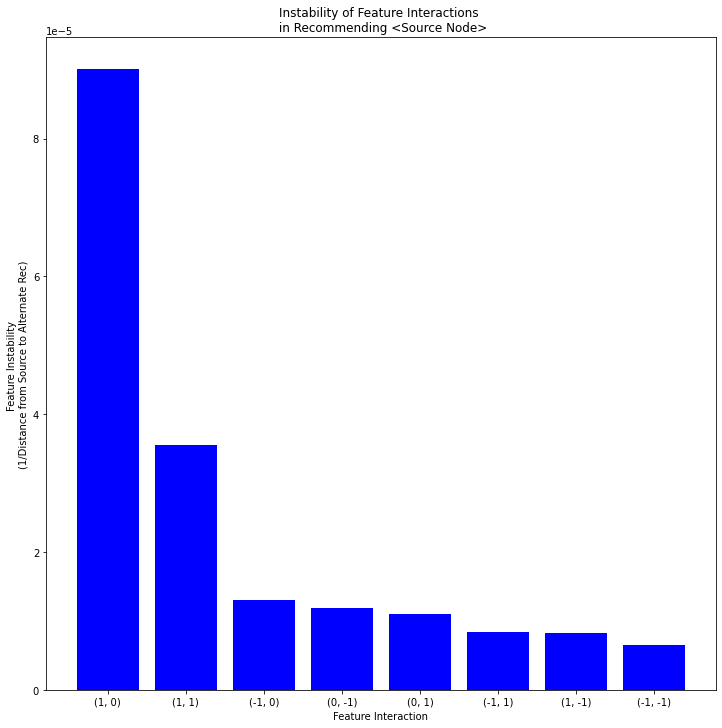

In [618]:
#Return node with estimated minimum distance from source node
def find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, nsteps=100):
    
    print("query_node",query_node.position,"source_node",source_node.position)
    relative_pos = query_node.position - source_node.position
    step_sizes = (relative_pos/nsteps) #How large of a step to take for each respective int feature
    #relative_feat_scaler = 1/np.asarray(relative_pos) #Scale to normalize feature step size when calculating distance

    print("\nMake Feat Steps")
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(relative_pos)):
        print('feat step 1')
        print(step_sizes[feat],relative_pos[feat],step_sizes[feat])
        print('feat step 2')
        if step_sizes[feat] > 0:
            feat_steps.append(np.arange(step_sizes[feat],relative_pos[feat],step_sizes[feat]))
        else:
            feat_steps.append(np.zeros(nsteps))
    for feat in feat_steps:
        np.flip(feat)
    feat_steps = np.asarray(feat_steps)
    print("feat_steps:",feat_steps)
    

    source_rec = query_synth_model(ground_truth_importance, source_node, source_node)
    query_rec = query_synth_model(ground_truth_importance, source_node, query_node)
    if source_rec != query_rec:
        solution_clusters = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler)
    
    print("Steps to locate min cluster")
    min_node = query_node
    for step in range(nsteps-1):
        
        local_feat_step = []
        for feat in range(len(feat_steps)):
            local_feat_step.append(feat_steps[feat][step])
        scaled_vector_position = np.asarray(query_node.position - local_feat_step)
        scaled_vector = Node(scaled_vector_position, None)
        query_rec = query_synth_model(ground_truth_importance, source_node, scaled_vector)
        
        if source_rec == query_rec:
            break
        else:
            scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
            min_node = scaled_vector
            solution_clusters = cluster_feat_int(source_node, min_node, solution_clusters, feat_scaler)
            #print(min_node.position,end='')

    return solution_clusters, min_node


source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
feat_ranges = get_num_range(data, dense_features)
feat_scaler = 1/np.asarray(feat_ranges)
solution_clusters = {}
query_node = Node(np.asarray([100,100]), None)
query_node.distance = get_distance(source_node, query_node, feat_scaler)

np.random.seed(seed=10)

prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=3, k=20)
solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, k=1000)

sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
display_instability(sorted_clusters)

In [600]:
discovered = []
for key in solution_clusters.keys():
    for el in solution_clusters[key]:
        discovered.append(Node(el,None))

In [604]:
solution_clusters

{(1, 1): [array([112.58307013,   8.33688996]),
  array([111.45723943,   8.25352106]),
  array([110.33140873,   8.17015216]),
  array([109.20557803,   8.08678326]),
  array([108.07974733,   8.00341436]),
  array([106.95391663,   7.92004546]),
  array([105.82808593,   7.83667656]),
  array([104.70225523,   7.75330766]),
  array([103.57642452,   7.66993876]),
  array([102.45059382,   7.58656986]),
  array([101.32476312,   7.50320096]),
  array([100.19893242,   7.41983206]),
  array([99.07310172,  7.33646316]),
  array([97.94727102,  7.25309426]),
  array([96.82144032,  7.16972536]),
  array([95.69560961,  7.08635646]),
  array([94.56977891,  7.00298756]),
  array([93.44394821,  6.91961866]),
  array([92.31811751,  6.83624976]),
  array([91.19228681,  6.75288086]),
  array([90.06645611,  6.66951196]),
  array([88.94062541,  6.58614307]),
  array([87.81479471,  6.50277417]),
  array([86.688964  ,  6.41940527]),
  array([85.5631333 ,  6.33603637]),
  array([84.4373026 ,  6.25266747]),
  arra

Dark Blue: Initial Search
Green X: A* Cluster Search


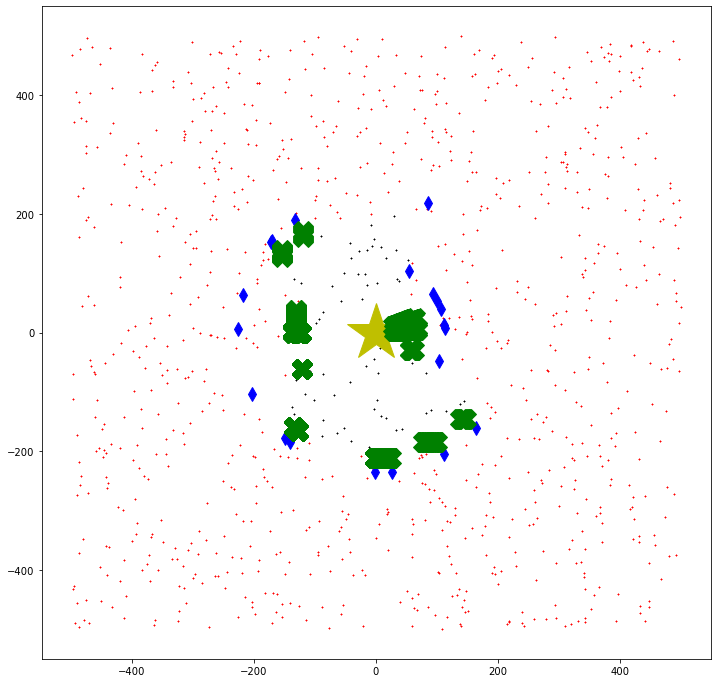

In [603]:
#Overlay true recs over feature space
plt.rcParams["figure.figsize"] = (12,12)
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-1/2*feat_range, high=1/2*feat_range, size=(nfeats,))
    query_node = Node(point, None)
    rec = query_synth_model(ground_truth_importance, source_node, query_node)
    if rec == 0:
        plt.plot(point[0],point[1],'k+',markersize=2)
    else:
        plt.plot(point[0],point[1],'r+',markersize=2)
        
plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=60)

        #  0.   1.   2.  3.   4.  5.   6.  7
colors = ['b^','gX','r','c^','k','md','y','bd']
#Display solutions of GD-FETS using discovered list
def plot_solutions(source_node, discovered,color_index=0,markersize=10):
    plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
    for point in discovered:
        plt.plot(point.position[0],point.position[1],colors[color_index],markersize=markersize)
    
plot_solutions(source_node, prelim_discovered,color_index=7,markersize=10)
plot_solutions(source_node, discovered, color_index=1,markersize=20)
#plot_solutions(source_node, refined_discovered,color_index=3,markersize=20)
print("Dark Blue: Initial Search")
print("Green X: A* Cluster Search")

 Prelim Solution Progress:
1234567891011121314151617181920
 Low LR A* Search Progress:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Nodes Visited: 6428
Nodes Generated: 7359
Visited Length: 7342
Cluster Denies: 313

 High LR A* Search Progress:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Nodes Visited: 16384
Nodes Generated: 16998
Visited Length: 16935
Cluster Denies: 627


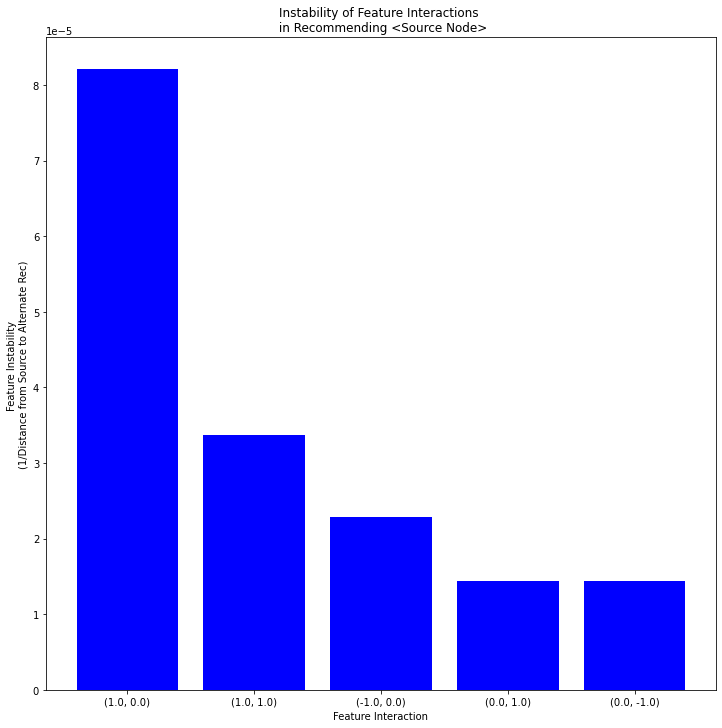

In [548]:
source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
feat_ranges = get_num_range(data, dense_features)
feat_scaler = 1/np.asarray(feat_ranges)

print(" Prelim Solution Progress:")
prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=5, k=20)
print("\n Low LR A* Search Progress:")
lr = feat_ranges[0] * 30
mid_discovered,solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, learning_rate=lr, k=100, max_cluster_size=20)
print("\n High LR A* Search Progress:")
lr = feat_ranges[0] * 5
refined_discovered,solution_clusters = a_star_search(source_node, mid_discovered, feat_ranges, k=50, learning_rate=lr, max_cluster_size=10)

plt.rcParams["figure.figsize"] = (12,12)
sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
display_instability(sorted_clusters)

AttributeError: 'numpy.ndarray' object has no attribute 'position'

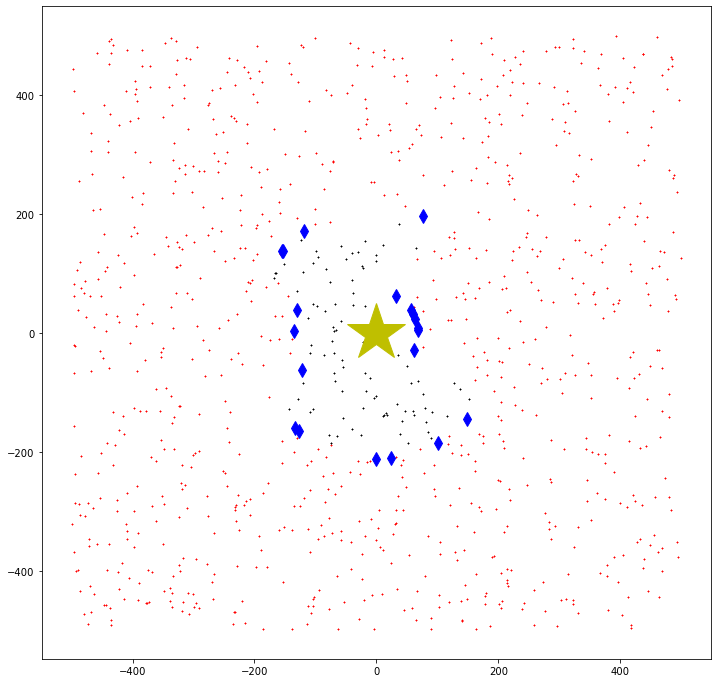

In [598]:
#Overlay true recs over feature space
plt.rcParams["figure.figsize"] = (12,12)
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-1/2*feat_range, high=1/2*feat_range, size=(nfeats,))
    query_node = Node(point, None)
    rec = query_synth_model(ground_truth_importance, source_node, query_node)
    if rec == 0:
        plt.plot(point[0],point[1],'k+',markersize=2)
    else:
        plt.plot(point[0],point[1],'r+',markersize=2)
        
plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=60)

        #  0.   1.   2.  3.   4.  5.   6.  7
colors = ['b^','gX','r','c^','k','md','y','bd']
#Display solutions of GD-FETS using discovered list
def plot_solutions(source_node, discovered,color_index=0,markersize=10):
    plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
    for point in discovered:
        plt.plot(point.position[0],point.position[1],colors[color_index],markersize=markersize)
    
plot_solutions(source_node, prelim_discovered,color_index=7,markersize=10)
plot_solutions(source_node, discovered, color_index=1,markersize=20)
#plot_solutions(source_node, refined_discovered,color_index=3,markersize=20)
print("Dark Blue: Initial Search")
print("Green X: A* Cluster Search")

(1.0, 0.0) : b^
(-1.0, 0.0) : gX
(0.0, 1.0) : r
(0.0, -1.0) : c^
(-1.0, -1.0) : k


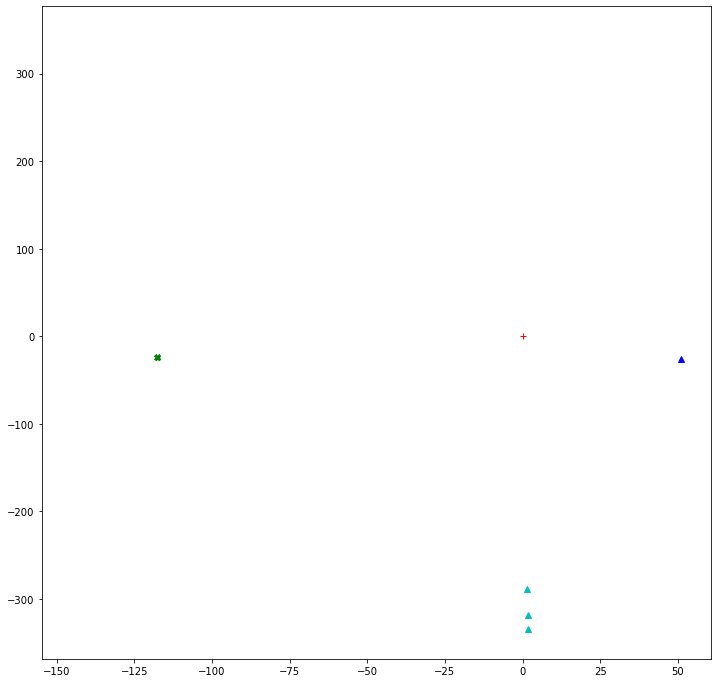

In [339]:
#Display solutions of GD-FETS using solution_clusters
plt.plot(source_node.position[0],source_node.position[1],'r+')
i=0
for cluster in solution_clusters:
    print(cluster,':',colors[i])
    for point in solution_clusters[cluster]:
        plt.plot(point[0],point[1],colors[i])
    i+=1

Test on Higher Dimensional Feature Space
-

In [290]:
d_dims = 3
source_node = Node(np.zeros(d_dims),0) #Want to explain this value

#Define scaling for features in synthetic "training data"
feat_ranges = np.zeros(d_dims) + 1000 #Assume all features have range 1000
feat_range = feat_ranges[0]
feat_scaler = 1/np.asarray(feat_ranges)

#Want GD-FETS to recreate these stability values thorugh local search
nclusters = 5
values = np.random.randint(low=0,high=feat_range, size=nclusters) #distance of cluster min to source_node
ground_truth_importance = {}
for i in range(nclusters):
    cluster_key = tuple(np.random.randint(low=-1,high=2, size=d_dims))
    ground_truth_importance[cluster_key] = values[i]
ground_truth_importance[tuple(np.zeros(d_dims))] = feat_range * 0.75 #default for every other feature interaction

TODO:
-
- Synthetic model should have continuous importance between features
- How to push GD-FETS adj neighbor search out of cluster when it is satisfied --> promote moving into space of adjacent feature-interaction cluster instead of redundantly showing density of feature-interactions in optimal cluster... A* should be able to identify optimal feature-interaction clusters given a high LR, to essentially walk down adjacent feat-int clusters
- A* Cluster search should redundantly look at small neighborhood distributed in cluster, and search each of them downward, saving the solution node that gives the smallest distance
- synthetic model that creates a smooth & continuous decision boundary between feature interactions
- Use mean of solutions in clusters as measure of feature stability?
- Implement LIME/SHAP to give comparison of their performance using a Ground Truth decision boundary, to that of GD-FETS
- Implement one-way feature-interaction for GD-FETS for direct comparison to LIME
- T-tests to demonstrate signifiance of GD-FETS identifying the same feature interactions as expreesed in the GT explanation --> Only shortest distance is logical, as the average would be impacted by search bias artefacts... can show this once solutions hug the decision boundary in each solution cluster

----
- Adjust abstract to provide brief intro on importance of deep recsys/DNN explainability, followed by a majority of key features of GD-FETS
- Describe evaluation methodology in manuscript, and describe results
- Would like to do: Use T-SNE to project categorical embedding vectors from 4 dimension to 2 (reduce complexity of search space), can also collapse the dimensionality to a single dimension, although => information loss
- Use generators to dynamically create one-hot encoding labels for training embedding inversion models, for features with very large dictionary sizes, due to memory constraints
- Future Direction: Implement reinforcement learning agent to repalce the A* search engine, as RL policy can learn the most common explanability for a given model and feature values, which can be leveraged fro search.

Prev:
-
- Generate Ground Truth (GT) evaluation model with manufactured decision boundary surrounding source node, to provide a GT of explainability as defined by the function that creates the search space. This function will be used to compare the accuracy of GD-FETS to LIME. It should build the decision boundary given input parameters of which feature interactions should have what degree of instability.
- Set limit of q solutions found per multi-way feature interaction, after finding k solutions with high learning rate
- find_adjs() to take certain step size based on learning rate
- Reject the generation of an adjacent node if it is too close to an existing solution, such that local maxima aren't overrepresented, giving a chance to find global maxima for a given feature-interaction cluster
- Implement solutions clustering method for identifying which multi-way feature interaction a sample is expressing
- Implement method to display the magnitude of instability for top-k feature interactions
- Use 2-3 Std devs of each feature of training data as feat_range for data distribution to ignore outliers that would cause certain features to be traversed with too large a step size

Rejected Ideas
-
- Set limit of k solutions found per multi-way feature interaction, such that after k solutions in a single feature-interaction cluster are found, every node in the priority queue that is a member of that cluster is removed, so that only other feature-interaction clusters are searched. =>  > k*(top_n_feat_ints_desired) must be identified --> How else to prevent the overwelming redundance of the single closest feature interaction in explaining a recommendation/prediction? --> Answer: larger learning rate s.t. more areas are covered, but this leads to less specificity near decision boundary of optimal positions
- Modify find_adjs() to only generate adjacents in direction of source node, to reduce memory complexity of frontier priority queue